In [1]:
import datetime
import nltk
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.dates import MinuteLocator, DateFormatter
from sklearn.metrics import silhouette_score
from typing import Dict, List
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

from src import utils
from src.data import process_transcripts
from src.data.make_corpus import Corpus, Vocabulary
from src.models.breakpoints import calc_breakpoints, merge_documents_breakpoints


ROOT_DIR = utils.get_project_root()
DATA_DIR = Path.joinpath(ROOT_DIR, 'data')
DATA_RAW_DIR = Path.joinpath(DATA_DIR, 'raw/cs-410')
INTERMEDATE_DATA_DIR = Path.joinpath(DATA_DIR, 'intermediate')

[nltk_data] Downloading package punkt to /home/bxjxrx7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bxjxrx7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bxjxrx7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bxjxrx7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Raw Transcript File
Within each transcript segment, the first line is an integer ID of the segment, the next line is the beginning and end time of the segment, and the rest of the lines is the text of the segment. Each segment is separated by a newline character.

#### First 15 lines of raw text file:

In [2]:
file_name = '04_week-4/02_week-4-lessons/01_lesson-4-1-probabilistic-retrieval-model-basic-idea.en.srt'
# file_name = '04_week-4/02_week-4-lessons/02_lesson-4-2-statistical-language-model.en.srt'
file_path = Path.joinpath(DATA_RAW_DIR, file_name)

# print first 10 lines of raw transcript file
with open(file_path, 'r') as f:
    i = 0
    for line in f:
        print(line, end='')
        i += 1
        if i == 15:
            break

1
00:00:00,086 --> 00:00:07,516
[SOUND]
This

2
00:00:07,516 --> 00:00:10,282
lecture is about
the Probabilistic Retrieval Model.

3
00:00:10,282 --> 00:00:11,805
In this lecture,

4


# Process Raw Transcript File
Process each trancript segment and store in a Segment class. Return a list of segments. Does not process the last segment as it's just music that play at the end of a lesson.

#### First three processed transcript Segment classes:

In [3]:
transcript_segments = process_transcripts.process_transcript(file_path)

# print out first 5 segments
for s in transcript_segments[:3]:
    print(s)

Segment(id=0, beg=datetime.datetime(1900, 1, 1, 0, 0, 0, 86000), end=datetime.datetime(1900, 1, 1, 0, 0, 7, 516000), text='[SOUND] This', tokens=None)
Segment(id=1, beg=datetime.datetime(1900, 1, 1, 0, 0, 7, 516000), end=datetime.datetime(1900, 1, 1, 0, 0, 10, 282000), text='lecture is about the Probabilistic Retrieval Model.', tokens=None)
Segment(id=2, beg=datetime.datetime(1900, 1, 1, 0, 0, 10, 282000), end=datetime.datetime(1900, 1, 1, 0, 0, 11, 805000), text='In this lecture,', tokens=None)


# Create Corpus
- Create a vocabulary set, a unique set of words in the transcript
- Combine the raw text segements at certain intervals, $T$, to create approximately $\frac{Total Time}{T}$ documents. Also, ensure that each document does not end in the middle of a sentence.
- Calcuate term-document fequency matrix
- Calculate similarity of time series of documents

In [4]:
time_intervals: List[int] = [5, 30, 45, 60]   # time intervals to split transcipt into documents
corpus_times: Dict[int, Corpus] = dict()      # store corpus class in dictionary

# create unique set of tokens
vocab = Vocabulary(transcript_segments, remove_stop_words=True, combine_ngrams=True, stem_words=True)  

for interval in time_intervals:
    
    # merge combines segments by time interval
    documents = utils.merge_documents_time_interval(vocab.transcript_segements, interval) 

    # class to store vocab set, merged documents, and perform calculations on them
    corpus = Corpus(vocab, documents)
    corpus.create_term_doc_freq_matrix()
    corpus.calc_similarity_ts()
    
    corpus_times[interval] = corpus

#### First 3 documents with length of approximately 30 seconds:

In [5]:
for i in range(3):
    print(corpus_times[30].documents[i])
    print()

Segment(id=0, beg=datetime.datetime(1900, 1, 1, 0, 0, 0, 86000), end=datetime.datetime(1900, 1, 1, 0, 0, 41, 822000), text="[SOUND] This lecture is about the Probabilistic Retrieval Model. In this lecture, we're going to continue the discussion of the Text Retrieval Methods. We're going to look at another kind of very different way to design ranking functions than the Vector Space Model that we discussed before. In probabilistic models, we define the ranking function, based on the probability that this document is relevant to this query.", tokens=['sound', 'lectur', 'probabilist', 'retriev', 'model', 'lectur', 'go', 'continu', 'discuss', 'text_retriev', 'method', 'go', 'look', 'anoth', 'kind', 'differ', 'way', 'design', 'rank', 'function', 'vector_space_model', 'discuss', 'probabilist', 'model', 'defin', 'rank', 'function', 'base', 'probabl', 'document', 'relev', 'queri'])

Segment(id=1, beg=datetime.datetime(1900, 1, 1, 0, 0, 41, 822000), end=datetime.datetime(1900, 1, 1, 0, 1, 11, 12

# Plot of Time Series at Different Time Intevals

### Cosine Similarity of 5 Second Sequential Transcript Segments
- Each transcript segment is approximately 1 to 2 sentences
- Cosine similarity is too noisy for such a short time interval

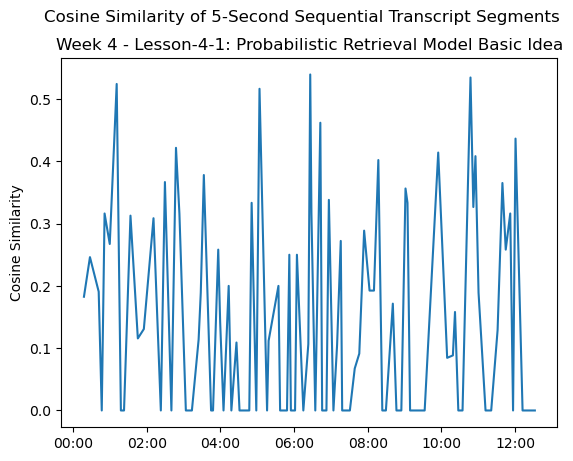

In [6]:
make_x_values = lambda docs: [d.end for d in docs[1:]]
fig, ax = plt.subplots(1, 1)
ax.plot(make_x_values(corpus_times[5].documents), corpus_times[5].ts_cos_similarity)
plt.ylabel('Cosine Similarity')
plt.suptitle('Cosine Similarity of 5-Second Sequential Transcript Segments')
plt.title('Week 4 - Lesson-4-1: Probabilistic Retrieval Model Basic Idea')

ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60), interval=2))
ax.xaxis.set_major_formatter(DateFormatter('%M:%S'))

### Cosine Similarity of 30, 45, and 60 Second Sequential Transcript Segments
- Longer transcript segments reduce variability of time series

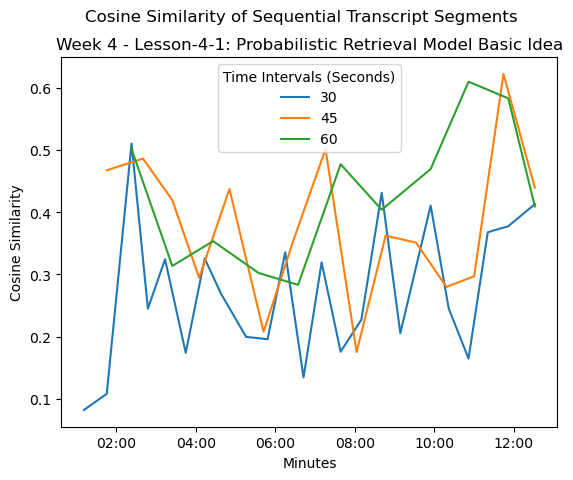

In [7]:
make_x_values = lambda docs: [d.end for d in docs[1:]]
fig, ax = plt.subplots(1, 1)
ax.plot(make_x_values(corpus_times[30].documents), corpus_times[30].ts_cos_similarity, make_x_values(corpus_times[45].documents), corpus_times[45].ts_cos_similarity, make_x_values(corpus_times[60].documents), corpus_times[60].ts_cos_similarity)
plt.legend(['30', '45', '60'], title='Time Intervals (Seconds)')
plt.xlabel('Minutes')
plt.ylabel('Cosine Similarity')
plt.suptitle('Cosine Similarity of Sequential Transcript Segments')
plt.title('Week 4 - Lesson-4-1: Probabilistic Retrieval Model Basic Idea')

ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60), interval=2))
ax.xaxis.set_major_formatter(DateFormatter('%M:%S'))

## Calc Breakpoints
Returns list of Segment indices of breakpoints

In [8]:
subtopics_corpuses: Dict[int, Corpus] = dict()
breakpoints_list: Dict[int, Corpus] = dict()
for interval in time_intervals:
    corpus = corpus_times[interval]
    breakpoints = calc_breakpoints(corpus.ts_cos_similarity)
    print(f'Breakpoints at {interval}-Second Interval:', breakpoints)
    breakpoints_list[interval] = breakpoints
    subtopics_documents = merge_documents_breakpoints(corpus.documents, breakpoints)
    topic_transitions_corpus = Corpus(corpus.vocab, subtopics_documents)
    topic_transitions_corpus.create_term_doc_freq_matrix()
    topic_transitions_corpus.calc_similarity_ts()

    # add to dict
    subtopics_corpuses[interval] = topic_transitions_corpus


Breakpoints at 5-Second Interval: [5, 10, 15, 20, 30, 35, 40, 45, 50, 55, 65, 70, 80, 85, 90, 95, 100]
Breakpoints at 30-Second Interval: [5, 10, 15, 20]
Breakpoints at 45-Second Interval: [5, 10]
Breakpoints at 60-Second Interval: [5]


## Plot Breakpoints

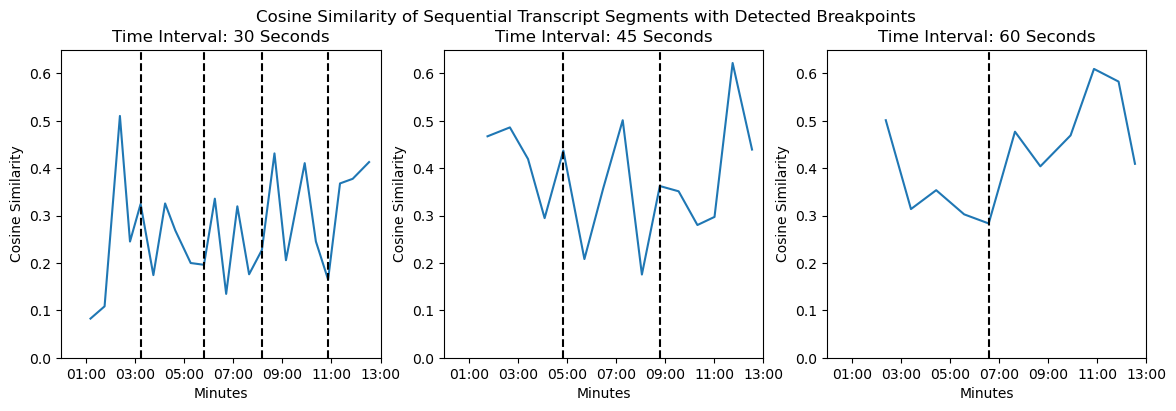

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (14, 4))
for i, interval in enumerate(time_intervals[1:]):   # skip 5 second interval
    axes[i].plot(make_x_values(corpus_times[interval].documents), corpus_times[interval].ts_cos_similarity)
    axes[i].vlines([corpus_times[interval].documents[b].end for b in breakpoints_list[interval]], [0] * len(breakpoints_list[interval]), [1] * len(breakpoints_list[interval]), colors='k', linestyles='dashed')
    axes[i].set_ylim(0, 0.65)
    axes[i].set_xlim(datetime.datetime(1900, 1, 1, 0, 0, 0), datetime.datetime(1900, 1, 1, 0, 13, 0),)
    axes[i].set_xlabel('Minutes')
    axes[i].set_ylabel('Cosine Similarity')
    plt.suptitle('Cosine Similarity of Sequential Transcript Segments with Detected Breakpoints')
    axes[i].set_title(f'Time Interval: {interval} Seconds')

    axes[i].xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60), interval=2))
    axes[i].xaxis.set_major_formatter(DateFormatter('%M:%S'))

## Evaluate Breakpoints
Calculate silhouette Scores

In [10]:
# divide raw transcript into 10 second intervals
base_corpus = Corpus(vocab, utils.merge_documents_time_interval(vocab.transcript_segements, 10))
base_corpus.create_term_doc_freq_matrix()

# create a mapping from 10 second interval to 60 second intervals
naive_time_label_map = utils.make_segment_label_mapping(base_corpus.documents, corpus_times[60].documents)
print('Naive, 60-Second Topic Transition:', silhouette_score(base_corpus.term_doc_freq_matrix.T, naive_time_label_map)) # naive, 60 second topic transition score
print()

for interval in time_intervals:

    # create a mapping from 10 second intervals to model predicted topic transitions
    subtopic_label_map = utils.make_segment_label_mapping(base_corpus.documents, subtopics_corpuses[interval].documents)

    # calculate silhouettes scores
    print(f'Estimated Breakpoints for {interval}-Second Intervals:', silhouette_score(base_corpus.term_doc_freq_matrix.T, subtopic_label_map))   # model topic transition score
    print()

Naive, 60-Second Topic Transition: -0.06225623204265577

Estimated Breakpoints for 5-Second Intervals: -0.08659163299710092

Estimated Breakpoints for 30-Second Intervals: -0.046675432583027726

Estimated Breakpoints for 45-Second Intervals: -0.017581536079201366

Estimated Breakpoints for 60-Second Intervals: 0.00565124769906185



In [11]:
for doc in subtopics_corpuses[60].documents:
    print('Segment ID:', doc.id)
    print(f'Interval: {doc.beg} --> {doc.end}')
    print('Text:')
    print(doc.text)
    print()

Segment ID: 0
Interval: 1900-01-01 00:00:00.086000 --> 1900-01-01 00:06:34.525000
Text:
[SOUND] This lecture is about the Probabilistic Retrieval Model. In this lecture, we're going to continue the discussion of the Text Retrieval Methods. We're going to look at another kind of very different way to design ranking functions than the Vector Space Model that we discussed before. In probabilistic models, we define the ranking function, based on the probability that this document is relevant to this query. In other words, we introduce a binary random variable here. This is the variable R here. And we also assume that the query and the documents are all observations from random variables. Note that in the vector-based models, we assume they are vectors, but here we assume they are the data observed from random variables. And so, the problem of retrieval becomes to estimate the probability of relevance. In this category of models, there are different variants. The classic probabilistic model